In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
article_tags = pd.read_csv("articles_tags.csv")
article_text = pd.read_csv("../resources/articles_text.csv")
article_tags= article_tags.set_index("Resource URL")
article_text = article_text.set_index("Resource URL")
article_text = article_text[~article_text.index.duplicated(keep='first')]

for i in article_text.index:
    article_text.loc[i, "tech_tag"] =  article_tags.loc[i]["Technical (Y/N)"][0]
    
data = (article_text[(article_text["tech_tag"]=="Y") | (article_text["tech_tag"]=="N")])
data_src = data
data_src = data_src[["Resource Title", "text", "tech_tag"]]
data_src.loc[:, "text"] =  data_src["Resource Title"] + " " +data_src["text"]
data_src.loc[:, "tech_tag"] = data_src["tech_tag"].map({"N": 0, "Y":1})
data_src.drop("Resource Title", axis=1, inplace=True)
data_src = data_src.dropna().reset_index(drop=True)
data=data_src

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
# NN PRED BASED

article_tags = pd.read_csv("nn_pred.csv")
article_tags = article_tags.set_index("Resource URL")

data = (article_tags[(article_tags["NN_Pred"]=="Y") | (article_tags["NN_Pred"]=="N")])
data_src = data
data_src = data_src[["Resource Title", "text", "NN_Pred"]]
data_src.loc[:, "text"] =  data_src["Resource Title"] + " " +data_src["text"]
data_src.loc[:, "NN_Pred"] = data_src["NN_Pred"].map({"N": 0, "Y":1})
data_src.drop("Resource Title", axis=1, inplace=True)
data_src = data_src.dropna().reset_index(drop=True)
data=data_src
data["tech_tag"] = data["NN_Pred"]

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((data.text, data.tech_tag))
VALIDATION_SIZE=250
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset  = dataset.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset  = dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [4]:
!pip install -q tf-models-official

In [5]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt

In [6]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-128_A-2' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
classifier_model = build_classifier_model()

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [11]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [12]:
classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [13]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Epoch 1/5
12/12 [==============================] - 15s 694ms/step - loss: 0.6893 - accuracy: 0.6213 - val_loss: 0.7393 - val_accuracy: 0.5720
Epoch 2/5
12/12 [==============================] - 8s 674ms/step - loss: 0.5528 - accuracy: 0.7347 - val_loss: 0.7285 - val_accuracy: 0.5600
Epoch 3/5
12/12 [==============================] - 8s 654ms/step - loss: 0.4712 - accuracy: 0.7960 - val_loss: 0.6902 - val_accuracy: 0.6320
Epoch 4/5
12/12 [==============================] - 8s 662ms/step - loss: 0.4379 - accuracy: 0.8213 - val_loss: 0.6703 - val_accuracy: 0.6520
Epoch 5/5
12/12 [==============================] - 8s 651ms/step - loss: 0.4080 - accuracy: 0.8480 - val_loss: 0.6693 - val_accuracy: 0.6440


In [14]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_dataset,
                               validation_data=test_dataset,
                               epochs=10)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Epoch 1/10
12/12 [==============================] - 8s 648ms/step - loss: 0.4042 - accuracy: 0.8520 - val_loss: 0.6693 - val_accuracy: 0.6440
Epoch 2/10
12/12 [==============================] - 8s 661ms/step - loss: 0.4135 - accuracy: 0.8413 - val_loss: 0.6693 - val_accuracy: 0.6440
Epoch 3/10
12/12 [==============================] - 8s 669ms/step - loss: 0.4138 - accuracy: 0.8600 - val_loss: 0.6693 - val_accuracy: 0.6440
Epoch 4/10
12/12 [==============================] - 8s 674ms/step - loss: 0.4091 - accuracy: 0.8547 - val_loss: 0.6693 - val_accuracy: 0.6440
Epoch 5/10
12/12 [==============================] - 8s 691ms/step - loss: 0.4122 - accuracy: 0.8280 - val_loss: 0.6693 - val_accuracy: 0.6440
Epoch 6/10
12/12 [==============================] - 8s 660ms/step - loss: 0.3982 - accuracy: 0.8600 - val_loss: 0.6693 - val_accuracy: 0.6440
Epoch 7/10
12/12 [==============================] - 8s 6

In [15]:
loss, accuracy = classifier_model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 2s 507ms/step - loss: 0.6693 - accuracy: 0.6440
Loss: 0.6693075895309448
Accuracy: 0.6439999938011169


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


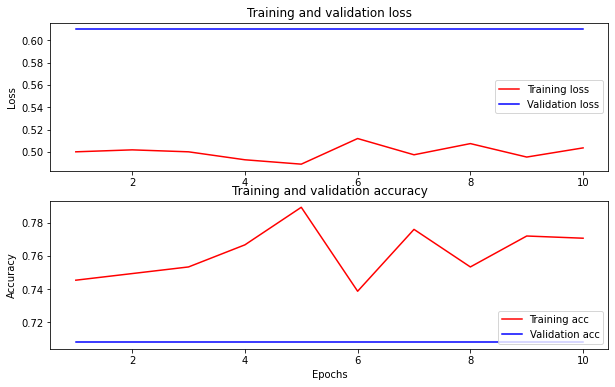

In [27]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [35]:
article_text = article_text[["text", "tech_tag"]]

In [20]:
hash_map = {'Y': 1, 'N': 0}

In [18]:
article_text =article_tags

In [21]:
for i in article_text.index:
    text = article_text.loc[i].text
    if article_text.loc[i].tech_tag not in hash_map.keys():
        continue
    target = hash_map[article_text.loc[i].tech_tag]
    if type(text) != type(' '):
        continue
    bert_raw_result = classifier_model.predict(tf.constant([text]))
    pred= tf.argmax(tf.sigmoid(bert_raw_result[0]))
    if pred!=target:
        print(i, "Predicted: ",pred.numpy(), " Actual: ", target)

https://www.nejm.org/doi/10.1056/NEJMc2104974 Predicted:  0  Actual:  1
https://jamanetwork.com/journals/jama/pages/coronavirus-alert Predicted:  0  Actual:  1
https://www.nejm.org/ Predicted:  0  Actual:  1
https://www.nejm.org/doi/full/10.1056/NEJMc2101951 Predicted:  0  Actual:  1
https://jamanetwork.com/journals/jama/fullarticle/2779850 Predicted:  0  Actual:  1
https://jamanetwork.com/ Predicted:  0  Actual:  1
https://jamanetwork.com/collections/5950/vaccination Predicted:  0  Actual:  1
https://jamanetwork.com/journals/jama/fullarticle/2779817 Predicted:  0  Actual:  1
https://jamanetwork.com/learning/audio-player/18608245 Predicted:  0  Actual:  1
https://www.nejm.org/doi/full/10.1056/NEJMe2103931 Predicted:  1  Actual:  0
https://jamanetwork.com/journals/jamaneurology/fullarticle/2779916 Predicted:  0  Actual:  1
https://www.nejm.org/medical-articles/perspective Predicted:  0  Actual:  1
https://www.nejm.org/pulmonary?topic=12&q=*&page=5 Predicted:  0  Actual:  1
https://jaman

In [62]:
bert_raw_result

array([[ 0.496458 , -0.2479827]], dtype=float32)

In [63]:
 tf.argmax(tf.sigmoid(bert_raw_result[0]))

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
[article_text[0:1].text]